# Assignment 2
# Ling Fei Zhang, 260985358
# Brandon Ma, 260983550

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SarsaAgent import *
import time
import gymnasium as gym
from tqdm import tqdm

c:\Users\Ling0\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Question 1

Here, we will set a few parameters for our environment.

In [2]:
ALPHAS = [0.001, 0.01, 0.05, 0.1]
GAMMA = 0.95
TEMPERATURE = [0.001, 0.01, 0.05, 0.1, 0.5, 50]
EPISODES = 5500
SEEDS = np.arange(10)
EPSILON = 0.2

## SARSA

Driver Code to test out the combination of each alpha with each temperature for SARSA.

In [3]:
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True)
env.reset()
sarsa = SARSA(env, 0.1, 0.5, GAMMA, EPISODES, False, EPSILON)
sarsa.simulate_episodes()
final_policy = sarsa.learned_policy
print("final policy:\n", final_policy.reshape(4,4)) #tabular format to better visualize
train_reward = sarsa.train_reward()
print(f"train reward: {train_reward}")
test_reward = sarsa.test_reward()
print(f"test reward: {test_reward}")

#uncomment this line if you want to vizualize the game
# sarsa.visualize(10)

final policy:
 [[2. 3. 2. 3.]
 [1. 1. 0. 2.]
 [3. 2. 0. 2.]
 [0. 2. 3. 3.]]
train reward: 0.0
test reward: 0.0


### Effect of parameters on final training performance for SARSA

100%|██████████| 6/6 [04:57<00:00, 49.53s/it]


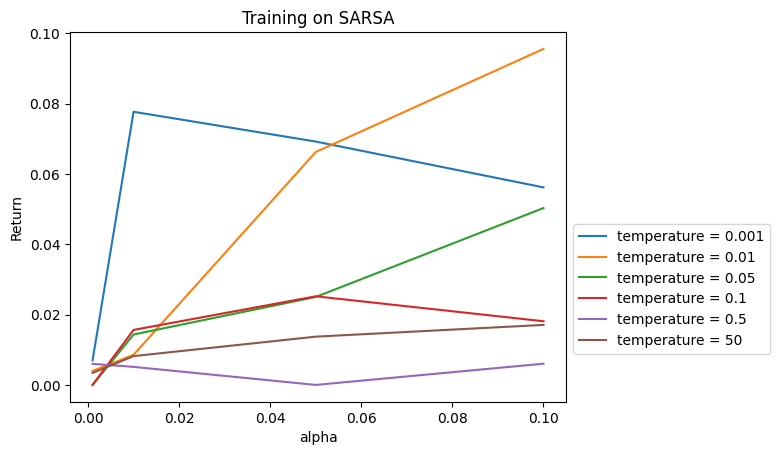

In [4]:
training_sarsa()

### Effect of parameters on final testing performance for SARSA

100%|██████████| 6/6 [05:03<00:00, 50.58s/it]


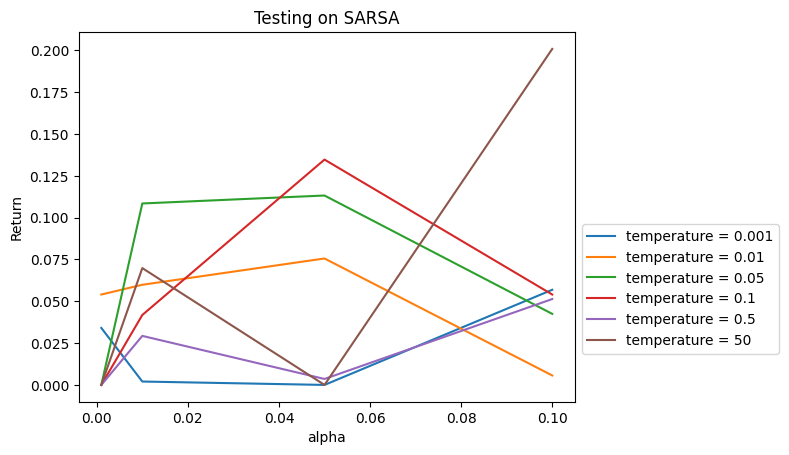

In [5]:
testing_sarsa()

### Best parameter for SARSA
We will pick the best hyperparameter based on the testing set. Then, the best paramaters for SARSA is when $\alpha = 0.1$ and temperature = 100. We can then use these parameters to plot a graph below

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


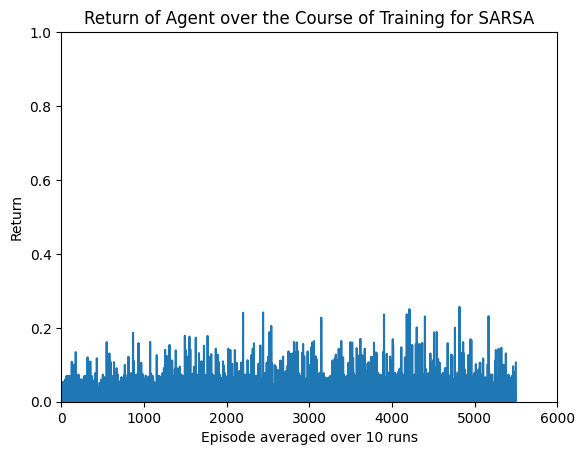

In [6]:
best_params_sarsa(0.1, 100)

### Conclusion for SARSA

First, we notice that the return by the agent is quite small. This can be due from a few different reasons. One of the main one is the fact that the environment is slippery. This means that the player will only move to its intended direction with probability $\frac{1}{3}$, and in either perpendicular directions with equal probability of $\frac{1}{3}$. This is a huge draw back for the agent, as it can not just follow the path that one would in a non-slippery environment. For example, if the environment is non-slippery and the agent is at the start state, then the optimal starting path for the agent would be to go down twice (state 1 to 5 to 9). However, given a slippery environment, the agent cannot choose to go down to state 5. This is because it has just a good a chance to go into the hole on the right, as it does to go down. Thus, it must learn to go left, in the hope to eventually slip downwards. However, this makes the number of steps per episode a lot larger, and thus decreases the return by the agent. 

Second, we can also analyze the effect of $\alpha$ on the graphs. $\alpha$ weights the importance of the TD error in the updating step. In other words, the importance in difference between the predicted value at a state-action pair and the boostrapped estimate. From our results, we observe that an $\alpha$ value of 0.6 is best during training, and $\alpha = 0.1$ is optimal during testing. 

Finally, we can see that a temperature of 50 is optimal for both the training process and the testing. As we use softmax exploration during learning, temperature is a hyperparameter that balances the probability distribution for a greedy pick and an equal pick between the state-action values. Since the softmax exploration is given as follows
\begin{equation*}
    \frac{\exp{(Q_t(s,a)/\tau)}}{\sum_{i \in A} \exp{(Q_t(s,i)/\tau)}}
\end{equation*}
we can see that as $\tau \rightarrow 0$, softmax exploration becomes like a greedy action selection. On the other hand, as $\tau \rightarrow \infty$, softmax results in picking an action at random (i.e. with equal probability). 

## Expected SARSA - NOT DONE, CHECK PROBABILITIES

Expected sarsa takes the weighted sum of all possible next actions. In other words, the next state action values are weighted in respect to the probability of taking that action. In our agent, we will implement the policy of choosing an action given the next state by using the softmax exploration. Formally, we have
\begin{equation*}
\pi(a|s_{t+1}) = \frac{e^{Q(a,s_{t+1})/\tau}}{\sum_{a \in A}e^{Q(a,s_{t+1})/\tau}}
\end{equation*}

### Effect of parameters on final training performance for Expected SARSA

100%|██████████| 6/6 [05:54<00:00, 59.02s/it]


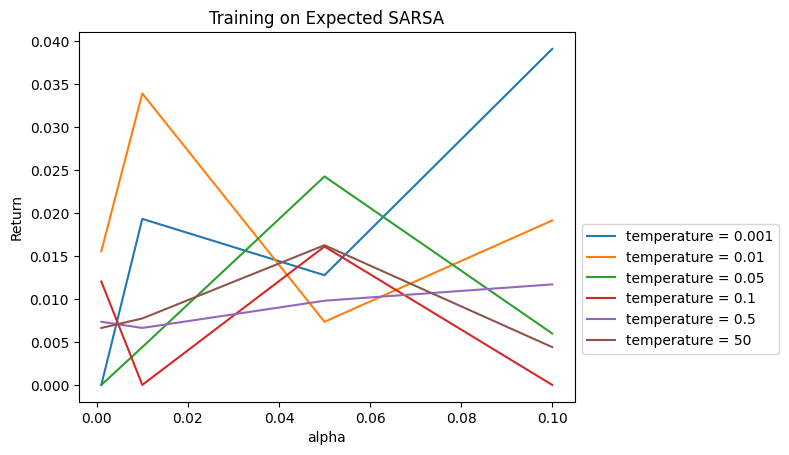

In [7]:
training_esarsa()

### Effect of parameters on final testing performance for Expected SARSA

100%|██████████| 6/6 [06:03<00:00, 60.56s/it]


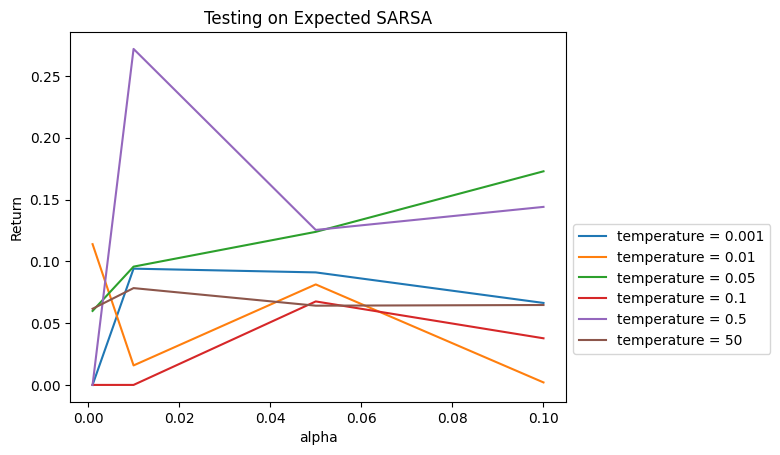

In [8]:
testing_esarsa()

### Best parameter for Expected SARSA

100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


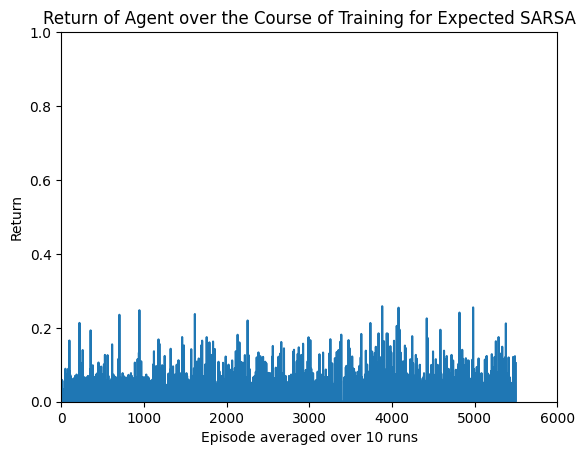

In [9]:
best_params_esarsa(0.1, 50)

### Conclusion for Expected SARSA

We observe that the results of Expected Sarsa is slightly higher than Sarsa. We see a maximal return of 0.4 with $\alpha = 0.3$ and temperature = 0.5 during testing using Expected Sarsa, while only slightly above 0.2 with $\alpha = 0.1$ and temperature = 50 with Sarsa. 

However, it's still worth mentioning that the return is nonetheless still small. This is because we know that the optimal path to the goal state can be achieved in 6 steps. In other words, we know that the optimal return that an agent can achieve is
$$
(0.95)^6 * 1 \approx 0.7350918906249998
$$
This again is a direct consequence of the slippery environment, where the intended direction by the agent is only achieved $\frac{1}{3}$ of the time. In fact, this completely changes the agent's strategy, and forces the agent to make safe and passive moves, which in turn increases the number of steps needed to reach the end goal. 

In Expected Sarsa, we observe the optimal $\alpha$ value to be 0.6 during training, and 0.3 during testing. On the same note, we observe the optimal temperature to be 50 during training and 0.5 during testing.

The effect of $\alpha$ and the temperature is the same as described in the conclusion for Sarsa, since the two algorithms are almost the same, with the exception of the update rule. 

## Sarsa vs Expected Sarsa Theoretical Trade Off

It's worth noting that Sarsa and Expected Sarsa are implemented almost identically, with the exception of the update rule. Sarsa is an on-policy algorithm, while Expected Sarsa can be either on-policy or off-policy. 

Overall, both Sarsa and Expected Sarsa have their own benefits. For instance, Expected Sarsa is able to achieve better returns since calculating the expected value over all future state-action pairs reduces variance from the random selection of the next action $A_{t+1}$. However, this is also more computationally expensive than Sarsa, since Sarsa only sample subsequent state action pairs stochastically. 